# Downloading dataset

In [1]:
!mkdir -p ~/.kaggle
!cp /content/drive/MyDrive/kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [2]:
!kaggle datasets download -d iabhishekofficial/mobile-price-classification

  0% 0.00/70.6k [00:00<?, ?B/s]
100% 70.6k/70.6k [00:00<00:00, 37.4MB/s]


In [3]:
!unzip mobile-price-classification.zip

Archive:  mobile-price-classification.zip
  inflating: test.csv                
  inflating: train.csv               


# Loading dataset

In [4]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [5]:
dataset = pd.read_csv('train.csv')

In [6]:
dataset.head()

,battery_power,blue,clock_speed,dual_sim,fc,four_g,int_memory,m_dep,mobile_wt,n_cores,...,px_height,px_width,ram,sc_h,sc_w,talk_time,three_g,touch_screen,wifi,price_range
0,842,0,2.2,0,1,0,7,0.6,188,2,...,20,756,2549,9,7,19,0,0,1,1
1,1021,1,0.5,1,0,1,53,0.7,136,3,...,905,1988,2631,17,3,7,1,1,0,2
2,563,1,0.5,1,2,1,41,0.9,145,5,...,1263,1716,2603,11,2,9,1,1,0,2
3,615,1,2.5,0,0,0,10,0.8,131,6,...,1216,1786,2769,16,8,11,1,0,0,2
4,1821,1,1.2,0,13,1,44,0.6,141,2,...,1208,1212,1411,8,2,15,1,1,0,1


#Preprocessing

Null values

In [7]:
dataset.isna().sum()

battery_power    0
blue             0
clock_speed      0
dual_sim         0
fc               0
four_g           0
int_memory       0
m_dep            0
mobile_wt        0
n_cores          0
pc               0
px_height        0
px_width         0
ram              0
sc_h             0
sc_w             0
talk_time        0
three_g          0
touch_screen     0
wifi             0
price_range      0
dtype: int64

Dealing with outliers

In [8]:
def detect_outlier(df,col_name):
  """
  Find indexes of outliers by computing IQR score

  Parameters
  ----------
  df : pd.DataFrame
       dataframe of dataset 
  col_name : str
             name of column you want to find outliers in
  Returns
  -------
  indexes : pd.Index
            indexes of outliers
  """

  q1 = np.percentile(df[col_name],25)
  q3 = np.percentile(df[col_name],75)
  iqr = q3 - q1
  lower = q1 - 1.5 * iqr
  upper = q3 + 1.5 * iqr
  indexes = df[(df[col_name] > upper) | (df[col_name] < lower)].index
  return indexes

In [9]:
dataset.shape

(2000, 21)

In [10]:
for col in ['battery_power','clock_speed','fc','int_memory','m_dep','mobile_wt','n_cores','pc','px_height',
            'px_width','ram','sc_h','sc_w','talk_time',]:
  if dataset[col].dtype == 'int64' or dataset[col].dtype == 'float64':
    outlier_indexes = detect_outlier(dataset,col)
    print(len(outlier_indexes),col)
    dataset.drop(outlier_indexes,inplace=True)

0 battery_power
0 clock_speed
18 fc
0 int_memory
0 m_dep
0 mobile_wt
0 n_cores
0 pc
2 px_height
0 px_width
0 ram
0 sc_h
0 sc_w
0 talk_time


In [11]:
dataset.shape

(1980, 21)

#Feature Selection


Forward Selection

In [12]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

In [13]:
def new_price(price):
  """
  Labeling 0 and 1 class of mobiles as low and 2 and 3 class of mobiles as high

  Parameters
  ----------
  price : int
          price range of mobile which can be 0, 1, 2, 3
  Returns
  -------
  indexes : str
            new label of instance
  """
  if price in [0,1]:
    return 'low'
  else:
    return 'high'

dataset['new_price'] = dataset.price_range.apply(new_price) 
dataset.drop('price_range',axis=1,inplace=True)

In [14]:
data = dataset.drop('new_price',axis=1)
target = dataset['new_price']
data_train, data_test, target_train, target_test = train_test_split(data,target,test_size=0.2,random_state=42)
data_train, data_val, target_train, target_val = train_test_split(data_train,target_train,test_size=0.25,random_state=42)

In [55]:
def forward_selection(data_train,target_train,data_val,target_val,n_features):
  """
  Forward feature selection
  At each step is added a feature to features list and computing corresponding auc score with features are selected so far and it is added to features_scores 

  Parameters
  ----------
  data_train : pd.DataFrame
               train dataset
  target_train : pd.Series
                 target of train dataset
  data_val : pd.DataFrame
             validation dataset
  target_val : pd.Series
               target of validation dataset
  n_features : int
                 number of features we want to select
  Returns
  -------
  features : list
             list of selected features
  features_scores : list
                    list of auc scores corresponding to model with selected features
  """
  features = []
  features_scores = []
  for _ in range(n_features):
    scores = []
    model = make_pipeline(StandardScaler(), LogisticRegression(max_iter=10000))
    for feature in data_train.columns:
      if feature not in features:
        copy_features = features.copy()
        copy_features.append(feature)
        model.fit(data_train[copy_features],target_train)
        scores.append((feature,evaluate_model(model,data_val[copy_features],target_val)))
    
    scores.sort(key=lambda x:x[1],reverse =True)
    features.append(scores[0][0])
    features_scores.append(scores[0][1])
  return features, features_scores


In [56]:
def evaluate_model(model,x_val,y_val):
  """
  compute auc score on validation set

  Parameters
  ----------
  model: sklearn.estimator
         model which we want to measure auc score of 
  x_val : pd.DataFrame
          validation set
  y_val : pd.Series
          target of validation set
  Returns
  -------
  auc_score : float
            auc score of model on validation set
  """
  predicted_proba = model.predict_proba(x_val)
  auc_score = roc_auc_score(y_val,predicted_proba[:,1])
  return auc_score

select all features and compute their scores

In [17]:
selected_features, scores = forward_selection(data_train,target_train,data_val,target_val,20)

In [18]:
selected_features

['ram',
 'battery_power',
 'px_width',
 'px_height',
 'wifi',
 'm_dep',
 'int_memory',
 'fc',
 'blue',
 'clock_speed',
 'n_cores',
 'pc',
 'touch_screen',
 'talk_time',
 'four_g',
 'sc_w',
 'dual_sim',
 'sc_h',
 'three_g',
 'mobile_wt']

In [19]:
scores

[0.9808633277827591,
 0.9908031254002818,
 0.9973101063148456,
 0.9995132573331625,
 0.9995644934033561,
 0.9996413475086461,
 0.9996925835788395,
 0.9997182016139362,
 0.9997182016139362,
 0.9997182016139362,
 0.9997182016139362,
 0.9997694376841296,
 0.999820673754323,
 0.999820673754323,
 0.999820673754323,
 0.9997438196490329,
 0.9996669655437428,
 0.9995901114384527,
 0.9993595491225823,
 0.9985653900345843]

In [20]:
best_features = selected_features[:4]
best_features

['ram', 'battery_power', 'px_width', 'px_height']

In [21]:
logistic_reg = make_pipeline(StandardScaler(),LogisticRegression())
logistic_reg.fit(data_train[best_features],target_train)
acc = logistic_reg.score(data_test[best_features],target_test)
print('accuracy of model:',acc)

accuracy of model: 0.9848484848484849


In [22]:
from sklearn.metrics import classification_report
predicted = logistic_reg.predict(data_test[best_features])
cr = classification_report(target_test,predicted,target_names=['high','low'])

print(cr)

              precision    recall  f1-score   support

        high       0.99      0.97      0.98       192
         low       0.98      1.00      0.99       204

    accuracy                           0.98       396
   macro avg       0.99      0.98      0.98       396
weighted avg       0.99      0.98      0.98       396



#PCA

In [23]:
from sklearn.decomposition import PCA

pca = PCA(n_components=4)
data = dataset.drop('new_price',axis=1)
target = dataset['new_price']
data_train, data_test, target_train, target_test = train_test_split(data,target,test_size=0.2,random_state=42)

data_train_transformed = pca.fit_transform(data_train)
data_test_transformed = pca.transform(data_test)

In [24]:
logistic_reg= LogisticRegression(max_iter=10000)
logistic_reg.fit(data_train_transformed,target_train)
acc_pca = logistic_reg.score(data_test_transformed,target_test)
print('accuracy of model:',acc_pca)

accuracy of model: 0.98989898989899


In [25]:
predicted = logistic_reg.predict(data_test_transformed)
cr = classification_report(target_test,predicted,target_names=['high','low'])
print(cr)

              precision    recall  f1-score   support

        high       0.99      0.99      0.99       192
         low       0.99      0.99      0.99       204

    accuracy                           0.99       396
   macro avg       0.99      0.99      0.99       396
weighted avg       0.99      0.99      0.99       396



#Feature Engineering

##Binning

In [26]:
min = dataset['battery_power'].min()
max = dataset['battery_power'].max()

bins = np.linspace(min,max,4)
bins

array([ 501., 1000., 1499., 1998.])

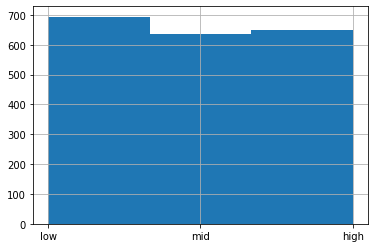

In [27]:
data = dataset.drop('new_price',axis=1)
target = dataset['new_price']

labels = ['low','mid','high']

data['battery_power'] = pd.cut(data['battery_power'],bins=bins,labels=labels,include_lowest=True)
data.battery_power.hist(bins=3)

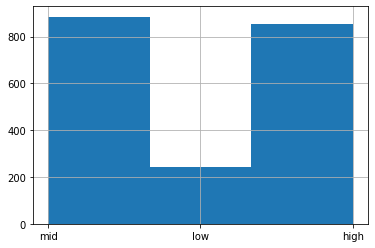

In [28]:
data = dataset.drop('new_price',axis=1)
target = dataset['new_price']

labels = ['low','mid','high']
bins = [0,666,1333,2000]
data['battery_power'] = pd.cut(data['battery_power'],bins=bins,labels=labels,include_lowest=True)
data.battery_power.hist(bins=3)

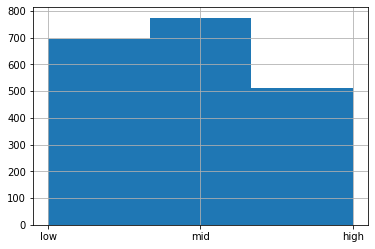

In [29]:
data = dataset.drop('new_price',axis=1)
target = dataset['new_price']

labels = ['low','mid','high']
bins = [0,1000,1600,2000]
data['battery_power'] = pd.cut(data['battery_power'],bins=bins,labels=labels,include_lowest=True)
data.battery_power.hist(bins=3)

##One-hot encoding

In [30]:
data = dataset.drop('new_price',axis=1)
target = dataset['new_price']

labels = ['low','mid','high']
bins = np.linspace(min,max,4)
data['battery_power'] = pd.cut(data['battery_power'],bins=bins,labels=labels,include_lowest=True)

In [31]:
onehot = pd.get_dummies(data['battery_power'],prefix = 'battery_power')
data = pd.concat([data,onehot],axis=1)
data.drop('battery_power',axis=1,inplace=True)

In [32]:
data.head()

,blue,clock_speed,dual_sim,fc,four_g,int_memory,m_dep,mobile_wt,n_cores,pc,...,ram,sc_h,sc_w,talk_time,three_g,touch_screen,wifi,battery_power_low,battery_power_mid,battery_power_high
0,0,2.2,0,1,0,7,0.6,188,2,2,...,2549,9,7,19,0,0,1,1,0,0
1,1,0.5,1,0,1,53,0.7,136,3,6,...,2631,17,3,7,1,1,0,0,1,0
2,1,0.5,1,2,1,41,0.9,145,5,6,...,2603,11,2,9,1,1,0,1,0,0
3,1,2.5,0,0,0,10,0.8,131,6,9,...,2769,16,8,11,1,0,0,1,0,0
4,1,1.2,0,13,1,44,0.6,141,2,14,...,1411,8,2,15,1,1,0,0,0,1


train a svm model and measuring its performance by cross validation

In [33]:
from sklearn.svm import SVC
from sklearn.model_selection import cross_validate

svm = SVC()
cv_result = cross_validate(svm,data,target,cv=5,n_jobs=-1)

In [34]:
mean_acc = cv_result['test_score'].mean()
print(f'Mean accuracy of model: {mean_acc:.3f} ')

Mean accuracy of model: 0.929 


## Transformation

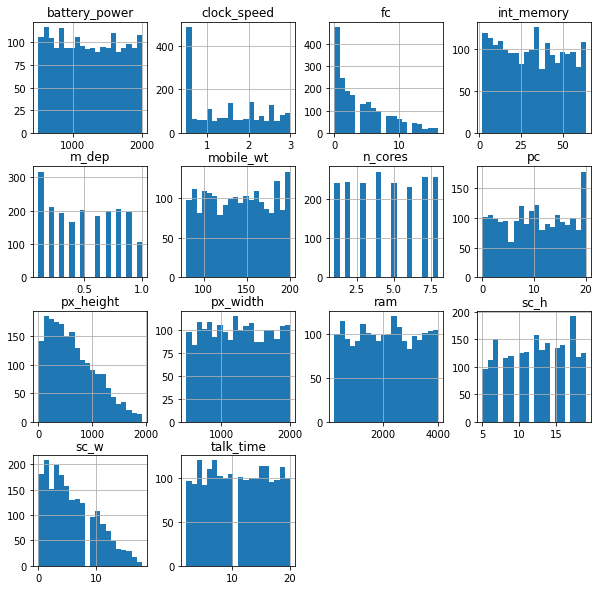

In [35]:
_ = dataset[['battery_power','clock_speed','fc','int_memory','m_dep','mobile_wt','n_cores','pc','px_height',
            'px_width','ram','sc_h','sc_w','talk_time',]].hist(figsize=(10,10),bins=20)


In [36]:
from sklearn.preprocessing import StandardScaler,QuantileTransformer
from sklearn.preprocessing import PowerTransformer
np.seterr(divide = 'ignore')

data = dataset.drop('new_price',axis=1)
target = dataset['new_price']

transformed_data = data.copy()
transformed_data['fc'] = np.log(transformed_data['fc']+1)
transformed_data['clock_speed'] = QuantileTransformer().fit_transform(transformed_data[['clock_speed']])

In [37]:
transformed_data['px_height'] = QuantileTransformer().fit_transform(transformed_data[['px_height']])
transformed_data['sc_w'] = QuantileTransformer().fit_transform(transformed_data[['sc_w']])

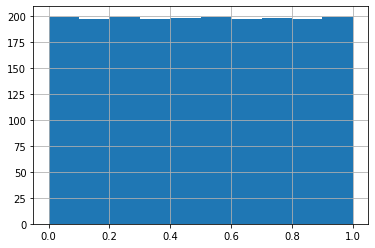

In [38]:
transformed_data['px_height'].hist()

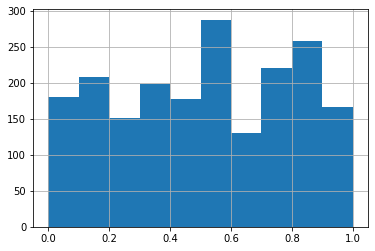

In [39]:
transformed_data['sc_w'].hist()

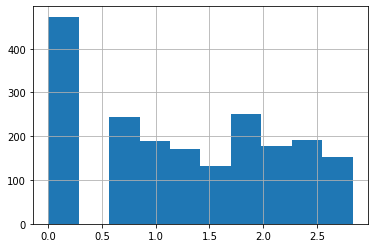

In [40]:
transformed_data['fc'].hist()

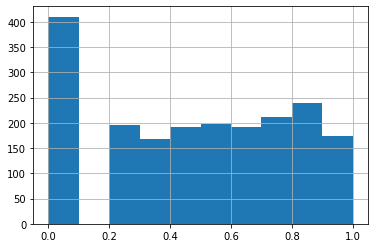

In [41]:
transformed_data['clock_speed'].hist()

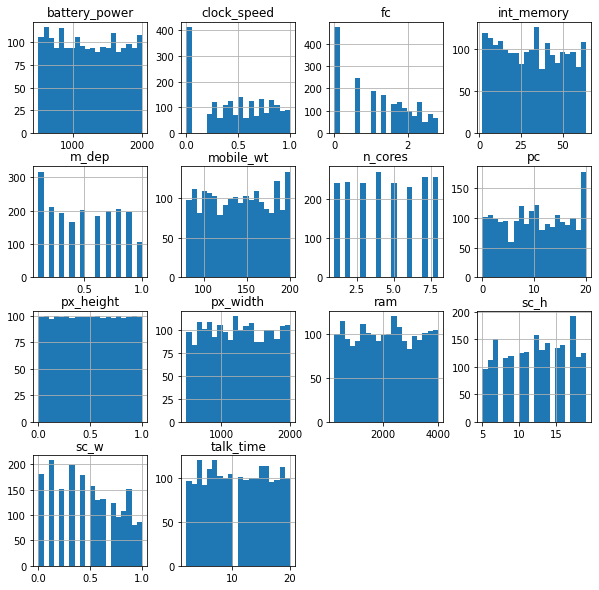

In [42]:
_ = transformed_data[['battery_power','clock_speed','fc','int_memory','m_dep','mobile_wt','n_cores','pc','px_height',
            'px_width','ram','sc_h','sc_w','talk_time',]].hist(figsize=(10,10),bins=20)
plt.savefig('new_dist.jpg')

In [43]:
from sklearn.compose import make_column_transformer

transformer = make_column_transformer((QuantileTransformer(),['clock_speed','px_height','sc_w']),remainder='passthrough')
svm = make_pipeline(transformer,SVC())

data = dataset.drop('new_price',axis=1)
target = dataset['new_price']

transformed_data = data.copy()
transformed_data['fc'] = np.log(transformed_data['fc']+1)

cv_result = cross_validate(svm,transformed_data,target,cv=5,n_jobs=-1)
mean_acc = cv_result['test_score'].mean()
print(f'Mean accuracy of model: {mean_acc:.3f} ')

Mean accuracy of model: 0.965 


## New Feature

In [44]:
data = dataset.drop('new_price',axis=1)
target = dataset['new_price']
data['area'] = data['sc_h'] * data['sc_w']

In [45]:
svm = SVC()
cv_result = cross_validate(svm,data,target,cv=5,n_jobs=-1)

In [46]:
mean_acc = cv_result['test_score'].mean()
print(f'Mean accuracy of model: {mean_acc:.3f} ')

Mean accuracy of model: 0.982 


## All Feature Engineering Steps

In [47]:
data = dataset.drop('new_price',axis=1)
target = dataset['new_price']

data['area'] = data['sc_h'] * data['sc_w']

labels = ['low','mid','high']
bins = np.linspace(min,max,4)
data['battery_power'] = pd.cut(data['battery_power'],bins=bins,labels=labels,include_lowest=True)

onehot = pd.get_dummies(data['battery_power'],prefix = 'battery_power')
data = pd.concat([data,onehot],axis=1)
data.drop('battery_power',axis=1,inplace=True)

data['fc'] = np.log(data['fc']+1)
data['area'] = np.log(data['area']+1)
# data['clock_speed'] = QuantileTransformer().fit_transform(data[['clock_speed']])
# data['px_height'] = QuantileTransformer().fit_transform(data[['px_height']])
# data['sc_w'] = QuantileTransformer().fit_transform(data[['sc_w']])


In [48]:
transformer = make_column_transformer((QuantileTransformer(),['clock_speed','px_height','sc_w']),remainder='passthrough')
svm = make_pipeline(transformer,SVC())
cv_result = cross_validate(svm,data,target,cv=5,n_jobs=-1)
mean_acc = cv_result['test_score'].mean()
print(f'Mean accuracy of model: {mean_acc:.3f} ')

Mean accuracy of model: 0.921 


#EXTRA


Backward Selection 

In [49]:
def backward_selection(data_train,target_train,data_val,target_val,n_features):
  """
  Backward feature selection
  At each step is removed a feature from features list and it is added to removed_feature
  and computing corresponding auc score with features are remaining so far and it is added to features_scores 

  Parameters
  ----------
  data_train : pd.DataFrame
               train dataset
  target_train : pd.Series
                 target of train dataset
  data_val : pd.DataFrame
             validation dataset
  target_val : pd.Series
               target of validation dataset
  n_features : int
               number of features we want to select
  Returns
  -------
  removed_features : list
                     list of removed features, in order of removing
  features_scores : list
                    list of auc scores corresponding to model with remaining features
  """
  features = list(data_train.columns)
  all_features_model = make_pipeline(StandardScaler(),LogisticRegression(max_iter=10000)).fit(data_train,target_train)
  features_scores = [evaluate_model(all_features_model,data_val,target_val)]
  removed_features = [' ',]
  for _ in range(n_features):
    scores = []
    # model = make_pipeline(StandardScaler(),LogisticRegression(max_iter=10000))
    for feature in data_train.columns:
      if feature in features:
        copy_features = features.copy()
        copy_features.remove(feature)
        if len(copy_features) == 0:
          break
        
        model = make_pipeline(StandardScaler(),LogisticRegression(max_iter=10000))
        model.fit(data_train[copy_features],target_train)
        scores.append((feature,evaluate_model(model,data_val[copy_features],target_val)))
    
    scores.sort(key=lambda x:x[1],reverse =True)
    # print(scores)
    if len(copy_features) == 0:
      break
    features.remove(scores[0][0])
    removed_features.append(scores[0][0])
    features_scores.append(scores[0][1])
    # print(removed_features)
  removed_features.extend(features)
  return removed_features,features_scores

In [50]:
data = dataset.drop('new_price',axis=1)
target = dataset['new_price']
data_train, data_test, target_train, target_test = train_test_split(data,target,test_size=0.2,random_state=42)
data_train, data_val, target_train, target_val = train_test_split(data_train,target_train,test_size=0.25,random_state=42)
removed_features,scores = backward_selection(data_train,target_train,data_val,target_val,20)

In [51]:
scores

[0.9985653900345843,
 0.9993595491225823,
 0.9995901114384527,
 0.9996925835788395,
 0.9996925835788395,
 0.9996925835788395,
 0.9996925835788395,
 0.9997950557192263,
 0.9997950557192263,
 0.9997694376841296,
 0.9997438196490329,
 0.9997694376841296,
 0.9997182016139362,
 0.9997182016139362,
 0.9996157294735495,
 0.9995644934033561,
 0.9995132573331625,
 0.9973101063148456,
 0.9908031254002818,
 0.9808633277827591]

In [52]:
best_features = removed_features[-4:]
best_features

['px_height', 'px_width', 'battery_power', 'ram']

In [53]:
logistic_reg = make_pipeline(StandardScaler(),LogisticRegression())
logistic_reg.fit(data_train[best_features],target_train)
acc_backward = logistic_reg.score(data_test[best_features],target_test)
print('accuracy of model:',acc_backward)

accuracy of model: 0.9848484848484849


In [54]:
predicted_backward = logistic_reg.predict(data_test[best_features])
cr = classification_report(target_test,predicted_backward,target_names=['high','low'])
print(cr)

              precision    recall  f1-score   support

        high       0.99      0.97      0.98       192
         low       0.98      1.00      0.99       204

    accuracy                           0.98       396
   macro avg       0.99      0.98      0.98       396
weighted avg       0.99      0.98      0.98       396

